In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
data_folder = "../testing_data"
filenames = []
testnames = []
propnames = []
cellnames = []
for filename in os.listdir(data_folder):
    if "Data" in filename:
        filenames.append(data_folder+"/"+filename)
        testnames.append(filename.split(".txt")[0].split("_")[3])
        propnames.append(filename.split("_")[2])
        cellnames.append(filename.split("_")[1])

In [4]:
filenames

['../testing_data/powerData_3s_5x4.5x3_A03.txt',
 '../testing_data/powerData_3s_8x4x2_C03.txt',
 '../testing_data/thrustData_2s_5x4.5x3_A01.txt',
 '../testing_data/thrustData_3s_5x4.5x3_A02.txt',
 '../testing_data/thrustData_3s_5x4.5x3_A03.txt',
 '../testing_data/thrustData_3s_5x4.5x3_G01.txt',
 '../testing_data/thrustData_3s_6x4x2_B01.txt',
 '../testing_data/thrustData_3s_8x4x2_C01.txt',
 '../testing_data/thrustData_3s_8x4x2_C02.txt',
 '../testing_data/thrustData_3s_8x4x2_C03.txt']

In [5]:
testnames

['A03', 'C03', 'A01', 'A02', 'A03', 'G01', 'B01', 'C01', 'C02', 'C03']

In [6]:
throttle = {}
thrust = {}
xfit = np.linspace(0,100,10)
thrustfit = {}

throttle_pow = {}
current = {}
power = {}
currentfit = {}
powerfit = {}

for filename,testname in zip(filenames,testnames):
    with open(filename,'r') as f:
        if "thrust" in filename:
            throttle[testname] = []
            thrust[testname] = []
            for line in f:
                if (not ("Throttle:" in  line)) and (not("Thrust:" in line)):
                    continue
                else:
                    thrustval = line.split("Thrust: ")[1].split(" grams")[0]
                    if not thrustval=='':
                        throttle[testname].append(float(line.split("Throttle: ")[1].split("%")[0]))
                        thrust[testname].append(float(thrustval))
            a,b,c = np.polyfit(throttle.get(testname),thrust.get(testname),2)
            thrustfit[testname] = a*xfit**2 + b*xfit + c
            
        elif "power" in filename:
            power[testname] = []
            current[testname] = []
            throttle_pow[testname] = []
            for line in f:
                if "Throttle" in line:
                    continue
                else:
                    splst = line.split(" | ")
                    throttle_pow[testname].append(float(splst[0].replace(" ","")))
                    current[testname].append(float(splst[1].replace(" ","")))
                    power[testname].append(float(splst[2].replace(" ",""))) 
            a,b,c = np.polyfit(throttle_pow.get(testname),current.get(testname),2)
            currentfit[testname] = a*xfit**2 + b*xfit + c
            a,b,c = np.polyfit(throttle_pow.get(testname),power.get(testname),2)
            powerfit[testname] = a*xfit**2 + b*xfit + c
            

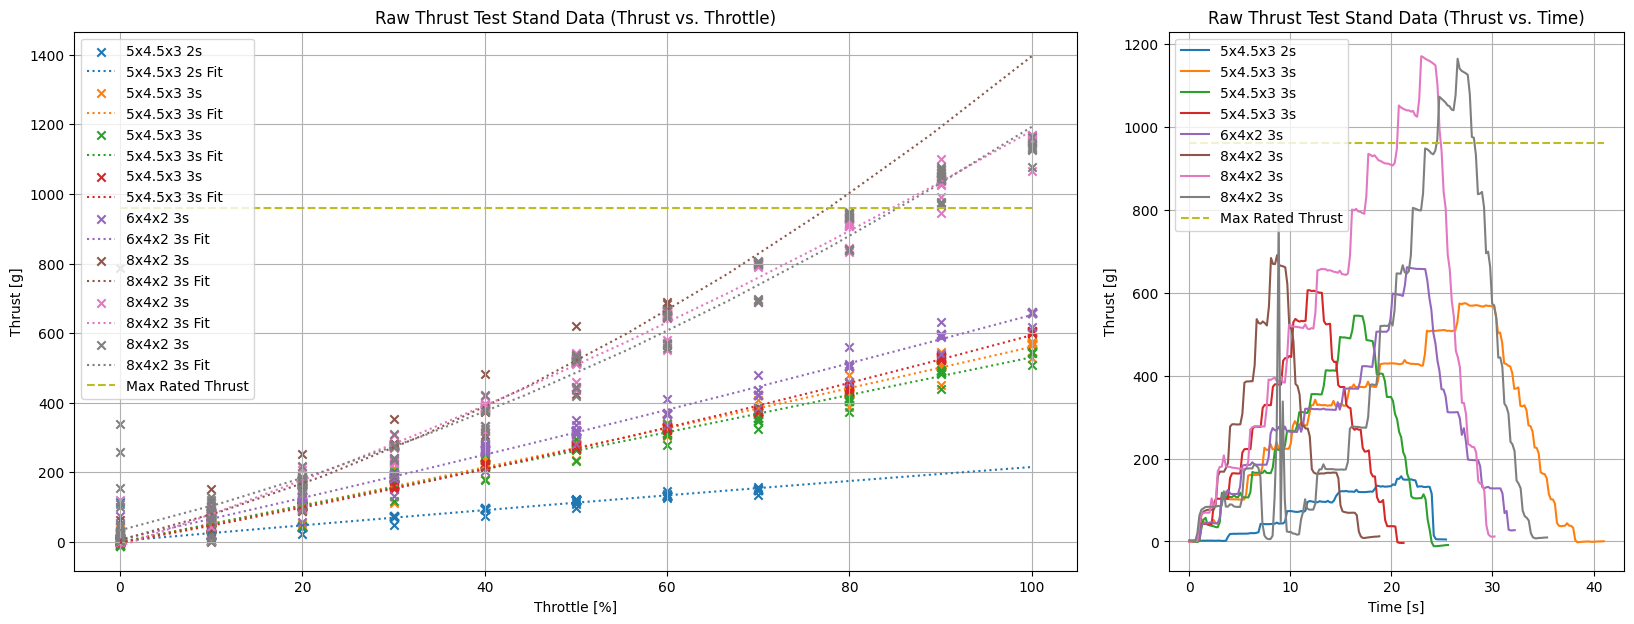

In [7]:
plt.figure(figsize=(20,7))
max_motor_pull = 960 # grams, as rated by manufacturer on amazon page: https://www.amazon.com/gp/product/B089YN9WM9/ref=ppx_yo_dt_b_search_asin_title?ie=UTF8&th=1 

# Raw Thrust Data Plot vs throttle
plt.subplot2grid((1,3),(0,0),colspan=2)
for filename,testname,propname,cellname in zip(filenames,testnames,propnames,cellnames):
    if "thrust" in filename: 
        plt.scatter(throttle.get(testname),thrust.get(testname),label=propname+" "+cellname,marker="x")
        plt.plot(xfit,thrustfit.get(testname),label=propname+" "+cellname+" Fit",linestyle=":")
plt.plot([0,100],[max_motor_pull,max_motor_pull],label="Max Rated Thrust",linestyle="--")
plt.xlabel("Throttle [%]")
plt.ylabel("Thrust [g]")
plt.grid()
plt.title("Raw Thrust Test Stand Data (Thrust vs. Throttle)")
plt.legend(loc="upper left")      


# Time based raw data
plt.subplot2grid((1,3),(0,2))
maxtimes = []
for filename,testname,propname,cellname in zip(filenames,testnames,propnames,cellnames):
    if "thrust" in filename:
        dtpts = len(thrust.get(testname))
        time = np.linspace(0,dtpts*0.2,dtpts)
        maxtimes.append(time[-1])
        plt.plot(time,thrust.get(testname),label=propname+" "+cellname)
plt.plot([0,max(maxtimes)],[max_motor_pull,max_motor_pull],label="Max Rated Thrust",linestyle="--")
plt.xlabel("Time [s]")
plt.ylabel("Thrust [g]")
plt.grid()
plt.title("Raw Thrust Test Stand Data (Thrust vs. Time)")
plt.legend(loc="upper left")

Text(0.5, 1.0, 'Power Draw Data')

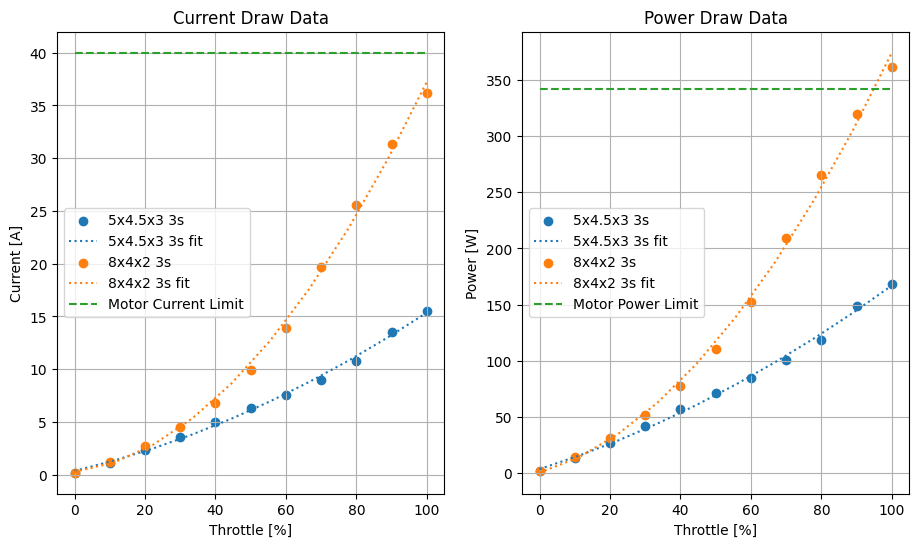

In [120]:
# Current/Power Data Plot
current_limit_motor = 40 # amps
power_limit_motor = 342 # W

plt.figure(figsize=(11,6))
plt.subplot(1,2,1)
for filename,testname,propname,cellname in zip(filenames,testnames,propnames,cellnames):
    if "power" in filename:
        plt.scatter(throttle_pow.get(testname),current.get(testname),label=propname+" "+cellname)
        plt.plot(xfit,currentfit.get(testname),label=propname+" "+cellname+" fit",linestyle=":")
plt.plot([0,100],[current_limit_motor,current_limit_motor],label="Motor Current Limit",linestyle="--")
plt.xlabel("Throttle [%]")
plt.ylabel("Current [A]")
plt.grid()
plt.legend()
plt.title("Current Draw Data")

plt.subplot(1,2,2)
for filename,testname,propname,cellname in zip(filenames,testnames,propnames,cellnames):
    if "power" in filename:
        plt.scatter(throttle_pow.get(testname),power.get(testname),label=propname+" "+cellname)
        plt.plot(xfit,powerfit.get(testname),label=propname+" "+cellname+" fit",linestyle=":")
plt.plot([0,100],[power_limit_motor,power_limit_motor],label="Motor Power Limit",linestyle="--")
plt.xlabel("Throttle [%]")
plt.ylabel("Power [W]")
plt.grid()
plt.legend()
plt.title("Power Draw Data")

In [139]:
# averaged data
avgthrust = {}
for testname in testnames:
    avgthrust[testname] = []
    oldthrottle = 0
    interimthrust = []
    for x,y in zip(throttle.get(testname),thrust.get(testname)):
        if oldthrottle==x:
            interimthrust.append(y)
            oldthrottle=x
        else:
            avgthrust[testname].append(np.average(interimthrust))
            interimthrust = []
            interimthrust.append(y)
            oldthrottle=x
    #throttle.get(testname) # has matching list of throttle vals
    #thrust.get(testname) # has list of thrust values

5-6 in propellers produce similar thrust, 5 has 3 vanes and 6 has 2. 5x4.5 vs 6x4<br>
8in propeller produces significantly more thrust, at a higher power consumption. Need to check if <br>
the current draw and overall power usage is below motor max of 40A and 342W. 

7in propellers may be the sweet spot if the power draw from 8x4 is too much.